<div class="alert alert-success">
    <center> <h1> <font size="8"> Dirichlet Example </font> </h1> </center>
</div>

<br/>
<br/>

The Dirichlet distribution is commonly used for modelling non-negative compositional data, i.e., data that consist of sub-sets that are fractions of some total. Compositional data are typically represented as proportions or percentages summing to 100\%, so that the Dirichlet extends the univariate beta-distribution to the multivariate case. Compositional data analysis (CoDa) is a branch of statistics that deals with multivariate observations carrying relative information and finds widespread use in ecology, economics or political science. As a result of the unit-sum constraint, models that use distributions designed for unconstrained data typically suffer from the problem of spurious correlation when applied to compositional data. 

In this example, we model and predict all parameters of a Dirichlet distribution with $Y_{D}=3$ target variables using the famous Arctic-Lake dataset. The density of the Dirichlet distribution with parameters $\mathbf{\alpha}_{\mathbf{x}} = (\alpha_{\mathbf{x},1}, \ldots, \alpha_{\mathbf{x},D}) \in \mathbb{R}^{D}_{+}$ with $\sum^{D}_{d=1}y_{d}=1$ for all $y_{d}\in \left[0,1\right]$ is given by

$$
f\big(\mathbf{y}|\mathbf{\theta}_{\mathbf{x}}\big) = \frac{1}{\mathrm{B}(\mathbf{\alpha}_{\mathbf{x}})} \prod_{d=1}^{D}y^{\alpha_{\mathbf{x},d-1}}_{d}
$$

To ensure positivity, the use can specify use a suitable response function $R(\alpha_{\mathbf{x},d})$ for all $d=1,\ldots, D$. The estimated parameters have the interpretation of providing the probability of an event falling into category $d$, i.e., $\mathbb{E}(y_{d}) = \frac{\alpha_{d}}{\alpha_{0}}$, with $\alpha_{0} = \sum^{D}_{d=1}\alpha_{d}$. Since XGBoostLSS is based on a *one vs. all estimation strategy*, where a separate tree is grown for each distributional parameter, **estimating many parameters for a large dataset can become computationally extremely expensive**. For more details, we refer to our related paper **[März, Alexander (2022), *Multi-Target XGBoostLSS Regression*](https://arxiv.org/abs/2210.06831)**.

<br/>
<br/>

# Dirichlet Regression

# Imports

In [ ]:
from xgboostlss.model import *
from xgboostlss.distributions.Dirichlet import *
from xgboostlss.datasets.data_loader import load_articlake_data

from sklearn.model_selection import train_test_split
import pandas as pd
import multiprocessing
import plotnine
from plotnine import *
plotnine.options.figure_size = (18, 9)
n_cpu = multiprocessing.cpu_count()

# Data

In [2]:
data = load_articlake_data()

# Due to the small sample size, we train on the entire dataset
x_train = data[["depth"]]
y_train = data.drop(columns="depth").values
n_targets = y_train.shape[1]
dtrain = xgb.DMatrix(x_train, label=y_train, nthread=n_cpu)

# Distribution Selection

In [3]:
# Specifies a Dirichlet distribution. See ?Dirichlet for details.
xgblss = XGBoostLSS(
    Dirichlet(D=n_targets,                      # Specifies the number of targets
              stabilization="None",             # Options are "None", "MAD", "L2".
              response_fn="exp",                # Function to transform the lower-triangular factor of the covariance, e.g., "exp", "relu" or "softplus".
              loss_fn="nll"                     # Loss function, i.e., nll.
             )               
)

# Hyper-Parameter Optimization

Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    - Float/Int sample_type
        - {"param_name": ["sample_type", low, high, log]}
            - sample_type: str, Type of sampling, e.g., "float" or "int"
            - low: int, Lower endpoint of the range of suggested values
            - high: int, Upper endpoint of the range of suggested values
            - log: bool, Flag to sample the value from the log domain or not
        - Example: {"eta": "float", low=1e-5, high=1, log=True]}

    - Categorical sample_type
        - {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            - sample_type: str, Type of sampling, either "categorical"
            - choice1, choice2, choice3, ...: str, Possible choices for the parameter
        - Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    - For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        - {"param_name": ["none", [value]]},
            - param_name: str, Name of the parameter
            - value: int, Value of the parameter
        - Example: {"gpu_id": ["none", [0]]}

Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are specified, max_depth is not used when gblinear is sampled, since it has no such argument.

In [4]:
param_dict = {
    "eta":              ["float", {"low": 1e-08,  "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 5,     "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "min_child_weight": ["float", {"low": 1e-8,   "high": 500,   "log": True}]
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=2,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=120,            # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=20,                # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-06-21 16:12:29,791] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization
C:\Users\maerzale\.virtualenvs\XGBoostLSS-vIPRRz-M\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-06-21 16:12:32,258] Trial 0 finished with value: -19.765962000000002 and parameters: {'eta': 3.5623752946431085e-07, 'max_depth': 1, 'gamma': 4.0777764217919787e-08, 'min_child_weight': 3.2270050801713505e-06, 'booster': 'gbtree'}. Best is trial 0 with value: -19.765962000000002.
[I 2023-06-21 16:12:33,572] Trial 1 finished with value: -39.1656265 and parameters: {'eta': 0.08832668402281392, 'max_depth': 2, 'gamma': 2.103048813930706e-05, 'min_child_weight': 0.0002905776860050202, 'booster': 'gbtree'}. Best is trial 1 with value: -39.1656265.
[I 2023-06-21 16:12:35,611] Trial 2 finished with value: -19.772727 and parameters: {'eta': 2.2096866886454325e-06, 'max_depth': 3, 'gamma': 1.8295275180845298, 'min_child_weight': 1.7565392988395257e-08, 'booster': 'gbtree'}. Best is trial 1 with value: -39.1656265.
[I 2023-06-21 16:12:37,404] Trial 3 finished with value: -19.764789999999998 and parameters: {'eta': 5.080034826525112e-08, 'max_depth': 4, 'gamma': 8.693694709232917, 'min_ch

# Model Training

In [6]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]
           
# Train Model with optimized hyperparameters
xgblss.train(
    opt_params,
    dtrain,
    num_boost_round=n_rounds
)

# Prediction

In [7]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = xgblss.predict(dtrain,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtrain,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = xgblss.predict(dtrain,
                             pred_type="parameters")

In [8]:
pred_samples.head()

,target,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,y1,0.762676,0.564338,0.720823,0.782023,0.801566,0.694309,0.815768,0.661441,0.846301,...,0.560072,0.684111,0.736884,0.861131,0.750103,0.708968,0.864005,0.774626,0.523831,0.766890
1,y1,0.710503,0.626665,0.657388,0.703910,0.789612,0.755503,0.674408,0.812226,0.540554,...,0.607728,0.803951,0.859105,0.627980,0.778375,0.611334,0.698094,0.602134,0.659841,0.707234
2,y1,0.554994,0.395319,0.621368,0.289958,0.496307,0.725910,0.503804,0.433935,0.772732,...,0.761914,0.846762,0.565901,0.810485,0.700059,0.831687,0.692086,0.621722,0.644248,0.513805
3,y1,0.431775,0.493828,0.684808,0.492462,0.611981,0.630222,0.671875,0.586538,0.644959,...,0.526325,0.724683,0.755367,0.789061,0.405648,0.683849,0.535184,0.808355,0.372292,0.580210
4,y1,0.551465,0.614277,0.749590,0.707169,0.696332,0.678802,0.641468,0.671597,0.568437,...,0.559330,0.569176,0.598099,0.573106,0.380101,0.433481,0.230152,0.680207,0.464203,0.775860


In [9]:
pred_samples.tail()

,target,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
112,y3,0.585305,0.488014,0.328665,0.481491,0.491275,0.480037,0.333955,0.488916,0.502609,...,0.322207,0.298224,0.535754,0.160303,0.293002,0.209309,0.349189,0.463586,0.525189,0.422365
113,y3,0.254224,0.444745,0.367978,0.317695,0.489593,0.215543,0.386071,0.432775,0.290261,...,0.439837,0.349197,0.381662,0.475623,0.291424,0.381766,0.463477,0.678408,0.437025,0.288925
114,y3,0.342703,0.623517,0.547842,0.488222,0.202155,0.495508,0.551350,0.306171,0.718764,...,0.397130,0.358518,0.429239,0.351855,0.391401,0.653229,0.613886,0.252139,0.454936,0.268518
115,y3,0.596377,0.504325,0.633847,0.305404,0.402728,0.516561,0.553921,0.581755,0.367090,...,0.432463,0.329129,0.277910,0.256414,0.624575,0.533113,0.570913,0.572807,0.262308,0.515276
116,y3,0.414857,0.356117,0.358782,0.441011,0.652874,0.553321,0.408551,0.498683,0.621328,...,0.572715,0.493789,0.422015,0.469451,0.493990,0.441861,0.570594,0.397282,0.345671,0.424686


In [10]:
pred_quantiles.head()

,target,quant_0.05,quant_0.95
0,y1,0.572545,0.878315
1,y1,0.509007,0.858218
2,y1,0.347877,0.785403
3,y1,0.355724,0.781666
4,y1,0.361046,0.792055


In [11]:
pred_params.head()

,concentration_1,concentration_2,concentration_3
0,14.826427,4.360004,1.050346
1,12.691727,4.360004,1.050346
2,7.774817,4.614791,1.050346
3,7.774817,4.614791,1.050346
4,7.914938,4.614791,0.925807


Please note that the **predicted parameters are not normalized to the simplex**. Yet, we can transform them easily as described above: the estimated parameters have the interpretation of providing the probability of an event falling into category $d$, i.e., $\mathbb{E}(y_{d}) = \frac{\alpha_{d}}{\alpha_{0}}$, with $\alpha_{0} = \sum^{D}_{d=1}\alpha_{d}$.

In [12]:
params_transf = pred_params.div(pred_params.sum(axis=1), axis=0)
params_transf.columns = data.columns[:-1]

params_transf.head()

,sand,silt,clay
0,0.732648,0.215450,0.051903
1,0.701120,0.240857,0.058024
2,0.578485,0.343364,0.078151
3,0.578485,0.343364,0.078151
4,0.588229,0.342966,0.068805


# SHAP Interpretability

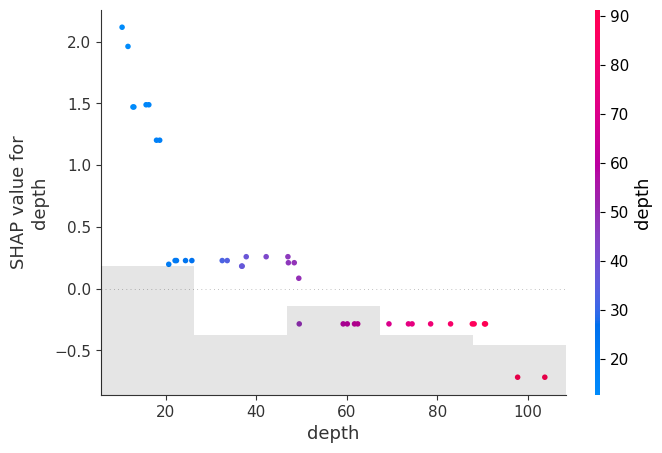

In [13]:
# Partial Dependence Plot of how depth acts on concentration_1
xgblss.plot(x_train,
            parameter="concentration_1",
            feature="depth",
            plot_type="Partial_Dependence")

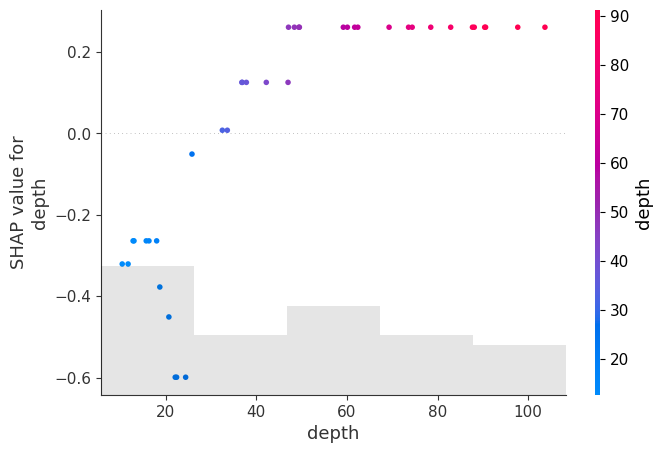

In [14]:
# Partial Dependence Plot of how depth acts on concentration_2
xgblss.plot(x_train,
            parameter="concentration_2",
            feature="depth",
            plot_type="Partial_Dependence")

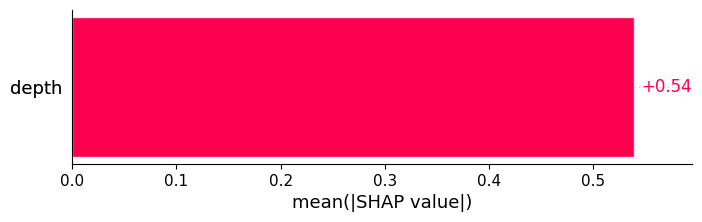

In [15]:
# Feature Importance of concentration_1 parameter
xgblss.plot(x_train,
            parameter="concentration_1",
            plot_type="Feature_Importance")

# Actual vs. Predicted
Since we predict the entire conditional distribution, we can overlay the point predictions with predicted densities, from which we can also derive quantiles of interest. We use the second response $y_{2}$ as an example.

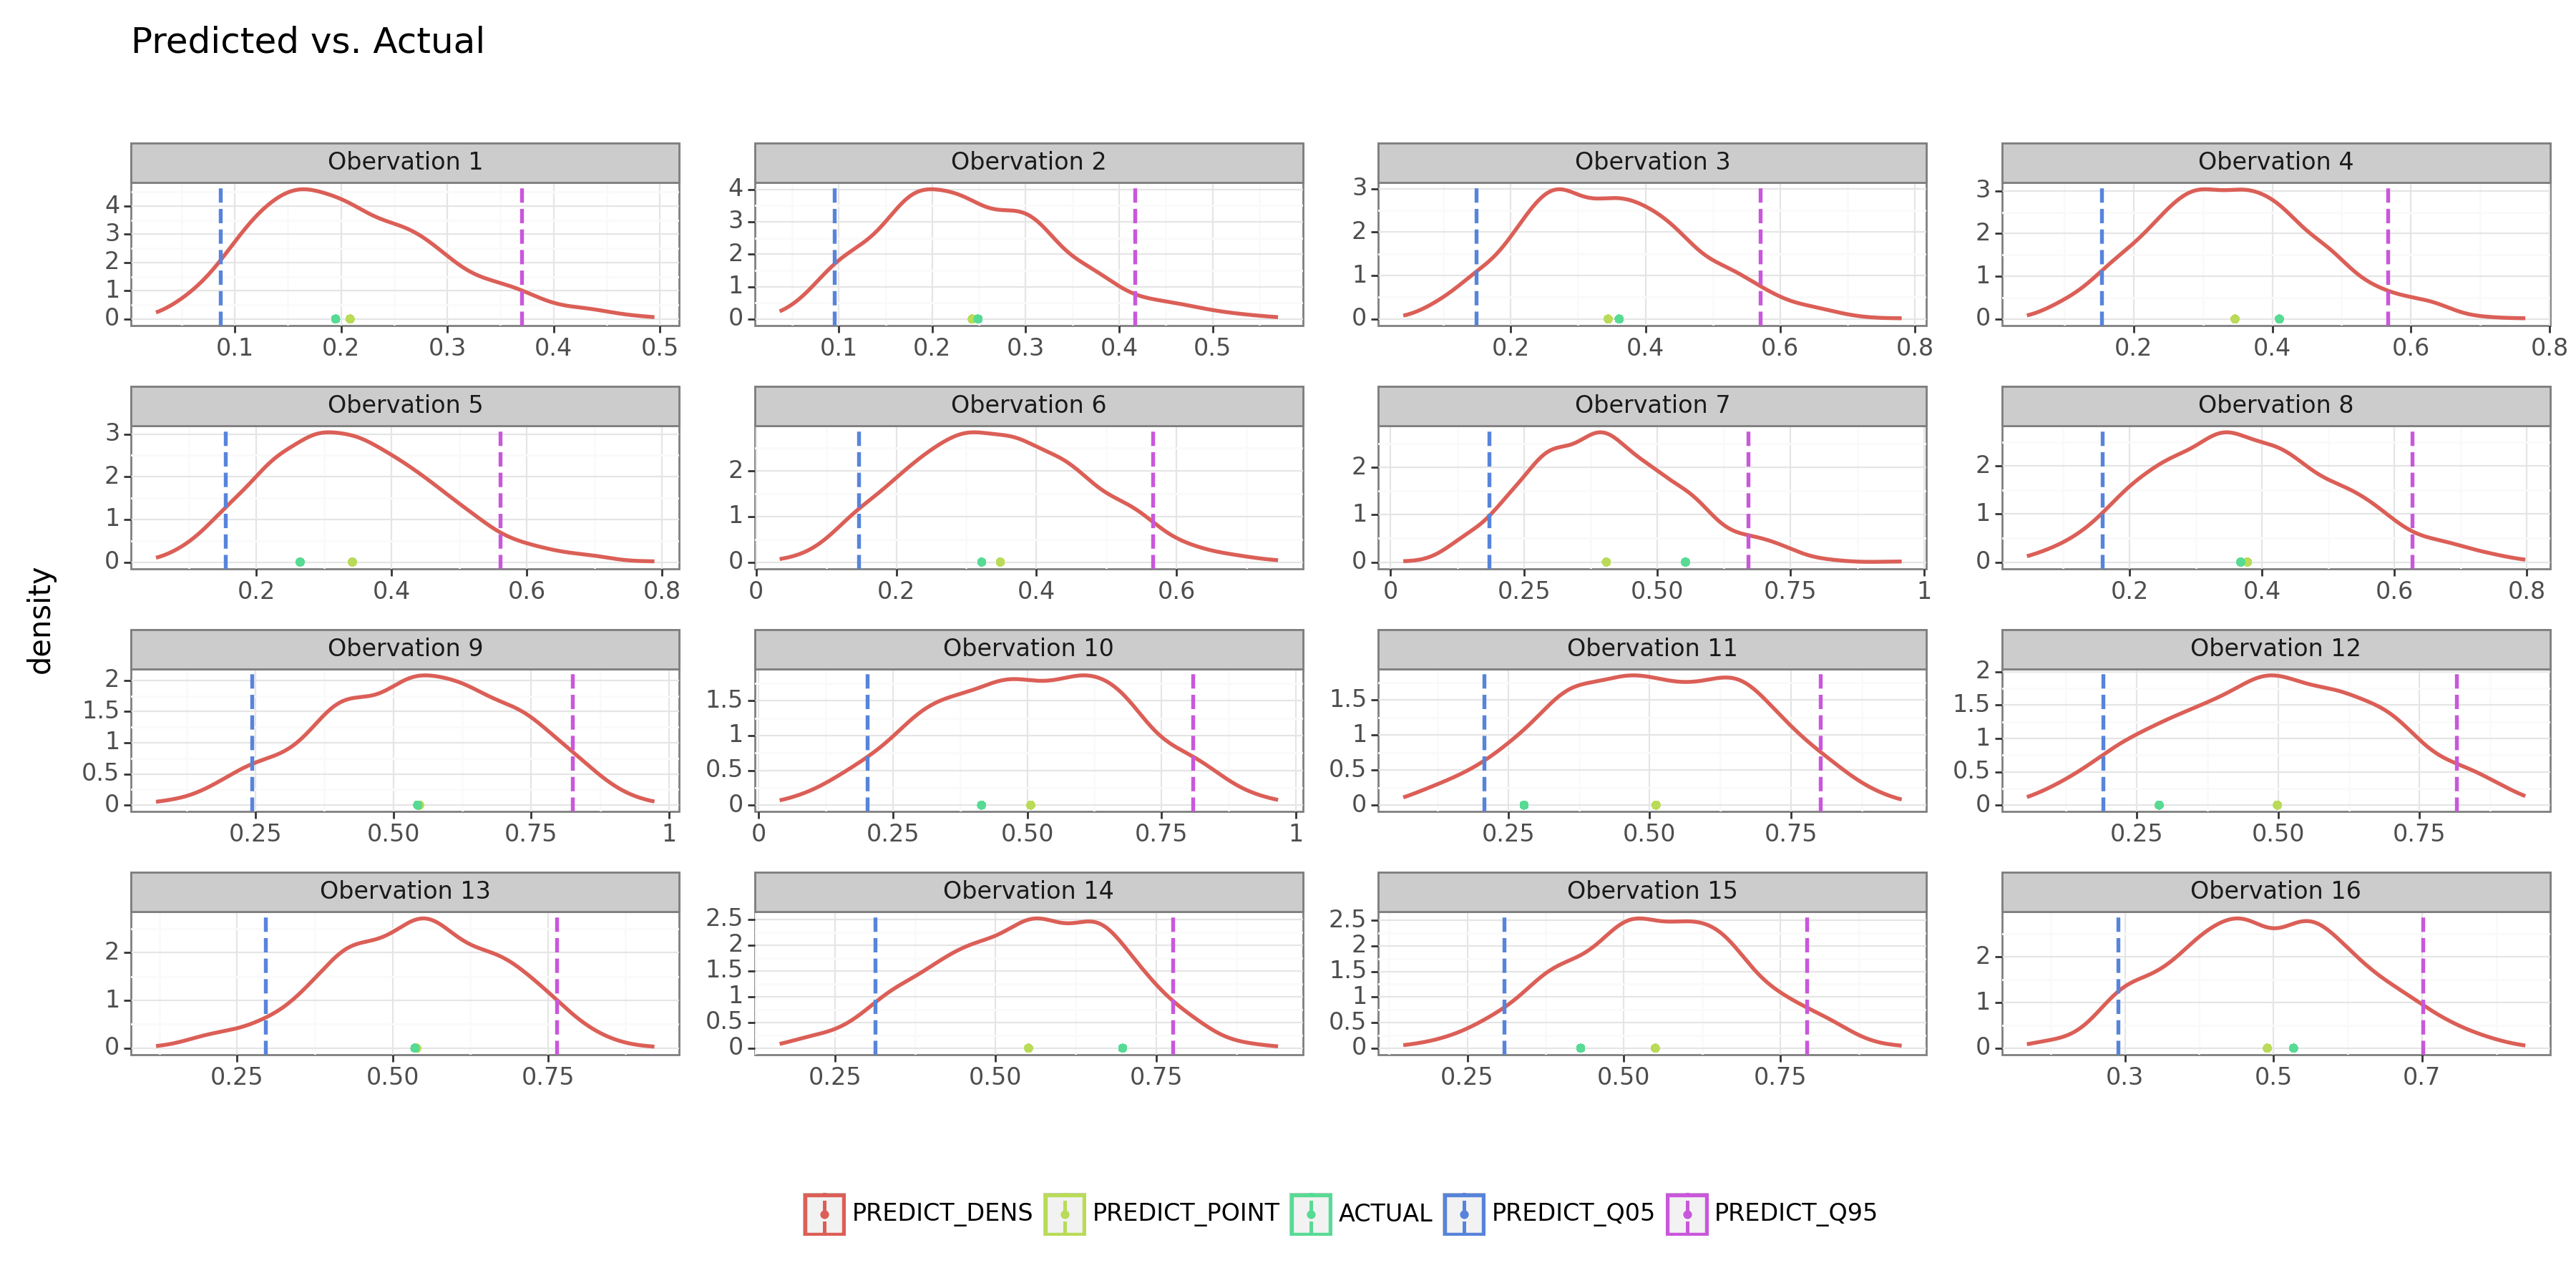

In [16]:
y_pred = []

n_examples = 16
q_sel = [0.05, 0.95]
y_sel=1
samples_arr = pred_samples.drop(columns="target").values.reshape(n_targets,-1,n_samples)

for i in range(n_examples):    
    y_samples = pd.DataFrame(samples_arr[y_sel,i,:].reshape(-1,1), columns=["PREDICT_DENS"])
    y_samples["PREDICT_POINT"] = y_samples["PREDICT_DENS"].mean()
    y_samples["PREDICT_Q05"] = y_samples["PREDICT_DENS"].quantile(q=q_sel[0])
    y_samples["PREDICT_Q95"] = y_samples["PREDICT_DENS"].quantile(q=q_sel[1])
    y_samples["ACTUAL"] = y_train[i,y_sel]
    y_samples["obs"]= f"Obervation {i+1}"
    y_pred.append(y_samples)
    
pred_df = pd.melt(pd.concat(y_pred, axis=0), id_vars="obs")
pred_df["obs"] = pd.Categorical(pred_df["obs"], categories=[f"Obervation {i+1}" for i in range(n_examples)])
df_actual, df_pred_dens, df_pred_point, df_q05, df_q95 = [x for _, x in pred_df.groupby("variable")]

plot_pred = (
    ggplot(pred_df,
           aes(color="variable")) + 
    stat_density(df_pred_dens,
                 aes(x="value"),
                 size=1.1) + 
    geom_point(df_pred_point,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_point(df_actual,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_vline(df_q05, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    geom_vline(df_q95, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    facet_wrap("obs",
               scales="free",
               ncol=4) + 
    labs(title="Predicted vs. Actual \n",
         x = "") + 
    theme_bw(base_size=15) +
    scale_fill_brewer(type="qual", palette="Dark2") + 
    theme(legend_position="bottom",
          legend_title = element_blank()
         )
)

print(plot_pred)